<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделим-датафрейм-на-выборки" data-toc-modified-id="Разделим-датафрейм-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделим датафрейм на выборки</a></span></li><li><span><a href="#Обучим-разные-модели" data-toc-modified-id="Обучим-разные-модели-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучим разные модели</a></span><ul class="toc-item"><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# импорт библиотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
RANDOM_STATE = 42

import numpy as np
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)

In [2]:
# импортируем датафрейм, переведем первый столбец в формат datetime и сделаем его индексом
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем

In [4]:
data.sort_index(inplace=True)

Проверим индекс на монотонность

In [5]:
data.index.is_monotonic 

True

Индекс монотонен

## Анализ

Так как в задании от нас требуют спрогнозировать количество заказов такси на следующий час, то вычислять агрегированное значение ряда мы будем суммой

Построим график количества заказов такси. Выберите интервал в час день, по каждому — вычислим суммарное энергопотребление

<AxesSubplot:xlabel='datetime'>

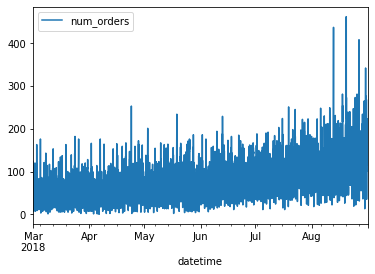

In [6]:
data = data.resample('1H').sum()
data.plot()

На графике видно, как постепенно увеличивается среднее значение, а также заметно постепенное увеличение дисперсии

Чтобы лучше понимать временной ряд, разберём тренды и сезонность

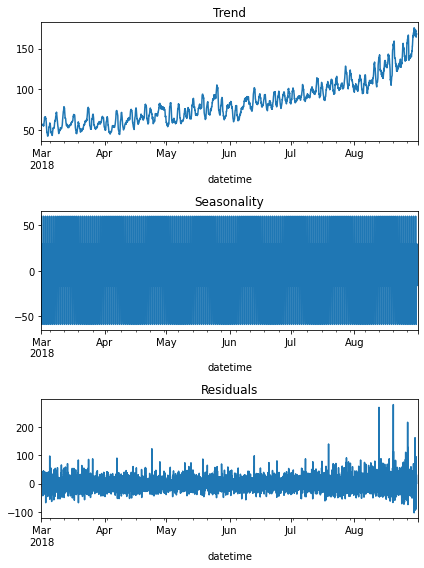

In [7]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Очевидно, что тренд идет на увеличение. 

<AxesSubplot:xlabel='datetime'>

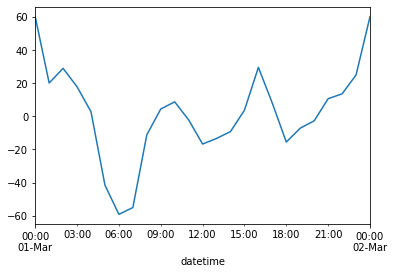

In [8]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot()

Мы видим, что час пик у нас выпадает на 00, на 16 и чуть меньше на 9. Кроме того, мы видим что в 6 утра заказов почти нет.

## Обучение

In [9]:
# создадим признаки для горизонта прогнозирования в один шаг
# напишем функцию для создания признаков

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [10]:
# вызовем функцию, укажем количество отстающих значений равное 20
# а скользящее среднее равное 24

make_features(data, 2, 24)

### Разделим датафрейм на выборки

In [11]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
# чтобы данные не перемешивались укажим shuffle=False

valid, train = train_test_split(train_valid, shuffle=False, test_size=0.6)

# из обучающей выборки удалим строки с пропусками
train = train.dropna()

train_features = train.drop(columns='num_orders')
train_target = train['num_orders']

valid_features = train.drop(columns='num_orders')
valid_target = train['num_orders']

test_features = test.drop(columns='num_orders')
test_target = test['num_orders']

### Обучим разные модели

#### Ridge

In [12]:
%%time

# random_state не перебирается, задаём его прямо в модели
model_ridge = Ridge(random_state=RANDOM_STATE)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

tscv = TimeSeriesSplit(n_splits=8)

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    cv=tscv, 
    verbose=1
)

gs_ridge.fit(train_features, train_target)

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_ridge.best_params_}')

Fitting 8 folds for each of 21 candidates, totalling 168 fits
best_score: 33.671723094601326
best_params: {'alpha': 0.0}
CPU times: user 1.13 s, sys: 430 ms, total: 1.56 s
Wall time: 1.55 s


#### RandomForestRegressor

In [14]:
%%time

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

param_grid_rf = {
    'n_estimators': range(100, 101),
    'max_depth': range(5, 10)
}

tscv = TimeSeriesSplit(n_splits=8)

gs_rf = GridSearchCV(
    model_rf, 
    param_grid=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_rf.fit(train_features, train_target)

gs_rf_best_score = gs_rf.best_score_ * -1
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 25.67686881138735
best_params: {'max_depth': 9, 'n_estimators': 100}
CPU times: user 8.58 s, sys: 84 ms, total: 8.66 s
Wall time: 8.67 s


Выберем RandomForestRegressor с параметрами {'max_depth': 9, 'n_estimators': 100}

## Тестирование

Проверим нашу модель на качество

In [ ]:
gs_rf_prediction = gs_rf.predict(test_features)
metric_test = mean_squared_error(test_target, gs_rf_prediction, squared=False)
metric_test

На тестовой выборке итоговое RMSE не превышает 48. Результат нас устраивает

Сравним наше предсказание с реальными данными. Построим график

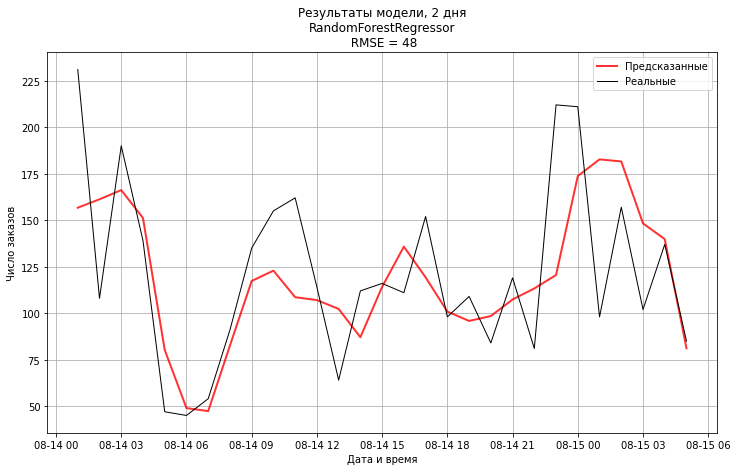

In [228]:
plt.figure(figsize=(12, 7))



df = pd.DataFrame({'date': test_features.index,
 'count_pred': prediction})

mask = (df['date'] > '2018-08-14 00:00:00') & (df['date'] < '2018-08-15 06:00:00')
# проиндексируем по столбцу date и выберем необходимый интервал для первого графика
df = df.loc[mask]






df2 = pd.DataFrame({'date': test_target.index,
 'count_target': test_target})

mask_2 = (df2['date'] > '2018-08-14 00:00:00') & (df2['date'] < '2018-08-15 06:00:00')
# проиндексируем по столбцу date и выберем необходимый интервал для второго графика
df2 = df2.loc[mask_2]



#plot both time series
plt.plot (df.date, df.count_pred , color= 'r', label='Предсказанные', linewidth = 2, alpha=0.8)
plt.plot (df2.date, df2.count_target , color= 'k', label='Реальные', linewidth = 1)

#add title and axis labels
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')


#add legend
plt.legend(loc="best")
plt.title("Результаты модели, 2 дня\nRandomForestRegressor\n RMSE = {}".format(round((mse)**0.5)))

plt.grid(True);


#display plot
plt.show() 

### Вывод

Мы проанализировали исторические данные о заказах такси в аэропортах компании «Чётенькое такси». Мы обратили внимание на пики и падения на сезонном графике. Кроме того мы создали функцию для создания признаков для горизонта прогнозирования в один шаг. И задали ею определенные значения, по которым вдальнейшем обучали и тестировали модели RandomForestRegressor и Ridge. Из них лучшей оказалась RandomForestRegressor. Она же показала на тестовых данных результат не более 48, что нас устраивает